In [65]:
import os.path
import pickle
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import librosa
from keras.utils import to_categorical
from constants import IMPROV_DURATION, NUM_MFCC, GENDERS, IMPROV_SR
from legacy.convert_iemocap_dataset_to_pkl import split_audio


base_path = '/Volumes/Kingston/datasets/audio/MSP-IMPROV/'
sessions = ['session1', 'session2', 'session3','session4', 'session5', 'session6']
classes = ['A', 'H', 'S', 'N']
scenarios = ['P','R','S','T']

Using TensorFlow backend.


In [8]:
def decode_filename(filename: str):
    speaker_gender = filename[16]
    speaker_id = filename[16:19]
    return speaker_gender, speaker_id

In [56]:
files_data = []

for session in sessions:
    for i in range(15):
        s = "S{:02d}".format(i + 1)
        for c in classes:
            for scenario in scenarios:
                dir = base_path + session + "/" + s + c + "/" + scenario + "/"
                if os.path.isdir(dir):
                    onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
                    for f in onlyfiles:
                        abs_filename = dir + "/" + f
                        speaker_gender, speaker_id = decode_filename(f)
    
                        file_data = {
                            'Filename': f,
                            'Path':abs_filename,
                            'Class': c,
                            'Gender': speaker_gender,
                            'Session': session,
                            'Sentence': s,
                            'Speaker_Id': speaker_id
                        }
    
                        files_data.append(file_data)
    
                else:
                    print("*************\t" + dir)

files_df = pd.DataFrame(files_data)

files_df.head()

files_df.to_csv('IMPROV_detail.csv')

*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11A/P/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11A/S/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11A/T/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11H/P/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11H/S/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11H/T/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11S/P/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11S/S/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11S/T/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11N/P/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11N/S/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S11N/T/
*************	/Volumes/Kingston/datasets/audio/MSP-IMPROV/session1/S12A/P/
*************	/Volumes/Ki

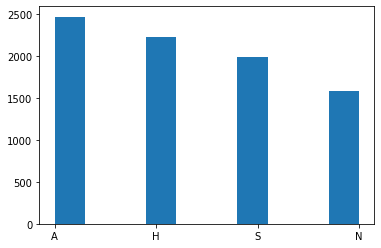

In [63]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(files_df['Class'])
plt.show()

## Processing Audio

In [66]:
def load_wav(filename, sr=None):
    audio, sr = librosa.load(filename, sr=sr)
    return audio, sr 

def remove_silent(signal, top_db=25):
    split_times = librosa.effects.split(signal, top_db=top_db)
    mix = []
    for s in split_times:
        part = signal[s[0]:s[1]]
        mix.extend(part)

    return np.array(mix)

# f = files_df['Path'][139]
# audio_file, sampling_ratio = load_wav(f)
# 
# plt.figure()
# plt.plot(audio_file)
# plt.show()

data = []

for index, row in files_df.iterrows():
    audio_file, sampling_ratio = load_wav(row['Path'],IMPROV_SR)
    audi = remove_silent(audio_file)
    
    frame = split_audio(audi,sampling_ratio,IMPROV_DURATION)[0]
    mfcc = librosa.feature.mfcc(frame,sampling_ratio, n_mfcc=NUM_MFCC)
    
    data.append({
        'x': mfcc,
        'emo': to_categorical(classes.index(row['Class']), num_classes=len(classes)),
        'gen': to_categorical(GENDERS.index(row['Gender']), num_classes=len(GENDERS)),
        'path': row['Path']
    })
data = np.array(data)

In [67]:
pkl_filename = 'improv-4_Class-sr_44k_2sec.pkl'
with open(pkl_filename, 'wb') as f:
    pickle.dump(data, f)